# DATA MINING PROJECT: Analysis of a Supermarket’s Customers
## 3.1) Predictive Analysis: new customer profile
### *Antonio Strippoli, Valerio Mariani*

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sn
from math import log
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

In [2]:
def plot(ax, folder="clustering_kmeans", filename="", figsize=(6.4, 4.8)):
    fig = plt.gcf()
    fig.set_size_inches(*figsize)
    plt.tight_layout()
    if filename:
        path = os.path.join("..", "report", "imgs", folder)
        if not os.path.exists(path):
            os.mkdir(path)
        plt.savefig(os.path.join(path, filename))
    plt.show()
    plt.close()

### Check for a good parameter for high-spending, medium-spending and low-spending customers

In [ ]:
# Load dataset
cdf = pd.read_csv("customer_profilation.csv", index_col=0)

In [ ]:
print(cdf['TotItems'].describe())
print(cdf['E-Sale'].describe())

In [ ]:
cdf = cdf[cdf['TotItems'] >= cdf['TotItems'].quantile(.25)]

In [ ]:
print(cdf['E-Sale'].describe())

In [ ]:
cdf = cdf[cdf['E-Sale'] >= cdf['E-Sale'].quantile(.25)]

In [ ]:
print(cdf['UniqueItems'].describe())
print(cdf['MeanItemSale'].describe())
cdf['SaleRate'] = cdf['Monetary'] / cdf['TotItems']
cdf.plot.scatter(x='UniqueItems', y='SaleRate')

In [ ]:
cdf['SaleRate'].describe()

In [ ]:
plot(cdf['MeanSale'].hist(bins=100))
plot(cdf['MeanSale'].plot.box())
cdf['MeanSale'].describe()

In [ ]:
q1, q3 = cdf['MeanSale'].quantile(.25), cdf['MeanSale'].quantile(.75)
def get_spending_class(x):
    if x < q1:
        return 0
    elif x < q3:
        return 1
    return 2  
cdf['SpendingClass'] = cdf['MeanSale'].apply(get_spending_class)

In [ ]:
cdf['SpendingClass'].hist()

NEW TRY

In [3]:
# Load the secondary data
df = pd.read_csv('customer_supermarket_2.csv', index_col=0, parse_dates=["PurchaseDate"])

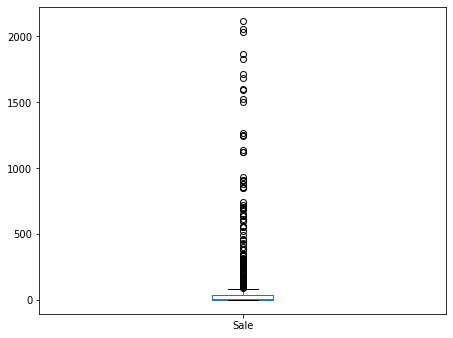

count     567.000000
mean      113.291869
std       308.147794
min         0.010000
25%         2.370000
50%         7.050000
75%        37.000000
max      2118.740000
Name: Sale, dtype: float64
0    240619
1    117109
2     36389
Name: PriceCategory, dtype: int64


<AxesSubplot:>

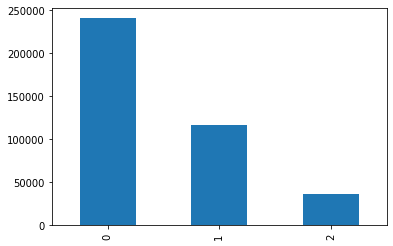

In [4]:
# Binning of unit price based on quantiles
df_sale = pd.Series(df['Sale'].unique(), name="Sale")
plot(df_sale.plot.box())
print(df_sale.describe())

q2, q3 = df_sale.quantile([.25, .5])

def categorize(sale):
    if sale < q2:
        return 0
    elif sale < q3:
        return 1
    return 2

df['PriceCategory'] = df['Sale'].apply(categorize)
print(df['PriceCategory'].value_counts())
df['PriceCategory'].value_counts().plot.bar()

In [5]:
# Total money spent
monetary = lambda g: round( sum( g["Sale"]*g["Qta"] ), 2)
# Total purchased items
n_transactions = lambda g: len(g)
# Total purchased items
tot_items = lambda g: sum( g["Qta"] )
# Items category
cat_0 = lambda g: sum( g[g['PriceCategory'] == 0]['Qta'] )
cat_1 = lambda g: sum( g[g['PriceCategory'] == 1]['Qta'] )
cat_2 = lambda g: sum( g[g['PriceCategory'] == 2]['Qta'] )

# TENIAMO?
# Number of distinct items
unique_items = lambda g: g["ProdID"].nunique()
def entropy(g, attr1, attr2, groupby, op):
    l = g[[attr1, attr2]].groupby(groupby).agg(op)
    m = l.values.sum()
    e = -sum( [ (mi/m)*log((mi/m), 2) for mi in l.values.flatten() ] )
    return round(e, 2)

In [6]:
groups = df[df["Qta"]>0].groupby("CustomerID")
cl = pd.DataFrame(data=np.array( [
    [
    group[0],
    monetary(group[1]),
    n_transactions(group[1]),
    tot_items(group[1]),
    cat_0(group[1]),
    cat_1(group[1]),
    cat_2(group[1]),
    unique_items(group[1]),
    entropy(group[1], "ProdID", 'Sale', 'ProdID', 'sum')
    ] for group in groups
] ), columns=["CustomerID","Monetary","NTransactions","TotItems","cat_0","cat_1","cat_2","UniqueItems","E-Sale"] )

for col in cl.columns:
    if col not in ["Monetary","E-Sale"]:
        cl[col] = cl[col].astype(np.int64)

cl.set_index('CustomerID', inplace=True)
print(cl)
cl.to_csv("classification.csv")

            Monetary  NTransactions  TotItems  cat_0  cat_1  cat_2  \
CustomerID                                                           
12347        4310.00            182      2458   1880    547     31   
12348        1797.24             31      2341   2332      0      9   
12349        1757.55             73       631    478    115     38   
12350         334.40             17       197    190      6      1   
12352        2506.04             85       536    354    146     36   
...              ...            ...       ...    ...    ...    ...   
18280         180.60             10        45      0     40      5   
18281          80.82              7        54     46      6      2   
18282         178.05             12       103     68     31      4   
18283        2094.88            689      1397   1271    122      4   
18287        1837.28             69      1586   1510     72      4   

            UniqueItems  E-Sale  
CustomerID                       
12347               1

In [7]:
cl = pd.read_csv("classification.csv", index_col=0)

bro = []
bro.append(cl['cat_0'].sum())
bro.append(cl['cat_1'].sum())
bro.append(cl['cat_2'].sum())

bro = pd.Series(bro)
bro

0    4011367
1     860538
2     114966
dtype: int64

In [8]:
# Prova a scremare
cl = pd.read_csv("classification.csv", index_col=0)
cl = cl[cl['TotItems'] >= cl['TotItems'].quantile(.25)]
cl = cl[cl['E-Sale'] >= cl['E-Sale'].quantile(.25)]

cl

,Monetary,NTransactions,TotItems,cat_0,cat_1,cat_2,UniqueItems,E-Sale
CustomerID,,,,,,,,
12347,4310.00,182,2458,1880,547,31,103,5.86
12354,1079.40,58,530,430,77,23,58,5.30
12356,2811.43,59,1591,1346,170,75,53,4.48
12357,6207.67,131,2708,1766,823,119,131,6.43
12359,6372.58,243,1622,1004,433,185,214,5.94
...,...,...,...,...,...,...,...,...
18263,1213.16,61,1468,1456,12,0,59,5.61
18265,771.51,44,309,202,91,16,43,5.06
18272,3078.58,166,2050,1702,338,10,99,6.07


In [9]:
cl['Mean_cat'] = cl[['cat_0', 'cat_1', 'cat_2']].idxmax(axis='columns')

<AxesSubplot:>

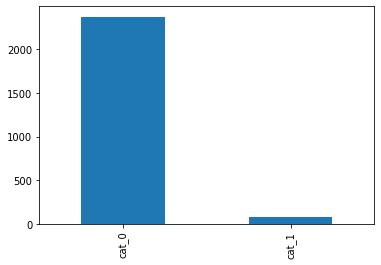

In [10]:
cl['Mean_cat'].value_counts().plot.bar()

Idea (valutare monetary oltre minitemsale):
- Impostare 2 soglie di sbarramento per identificare una categoria di utenti papabile per la classificazione
    - una soglia su Numero di transazioni
    - una sull'entropia
    - alla peggio un cazzo
- dopodiché puoi assumere che minitemsale sia un attributo significativo per la capacità di spesa dell'utente
- poi o lo dividiamo con kmeans o per quartili

In [ ]:
print(cl['NTransactions'].describe())
cl['NTransactions'].hist(bins=100)